This notebook shows the images from TFRecords.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import PIL

import os
import sys
from pathlib import Path
fdir = Path.cwd()
print(fdir)
sys.path.append(str(fdir/'..'))

/vol/ml/apartin/projects/pdx-histo/nbs


In [2]:
# # https://stackoverflow.com/questions/37893755/tensorflow-set-cuda-visible-devices-within-jupyter
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import glob
from pathlib import Path
from functools import partial

# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
assert tf.__version__ >= "2.0"

from tensorflow import keras

import src
from src.config import cfg
from src.utils.utils import Params
from src.tf_utils import get_tfr_files
from src.sf_utils import create_tf_data, parse_tfrec_fn_rsp

from src.tfrecords import FEA_SPEC, FEA_SPEC_RSP, FEA_SPEC_RNA, FEA_SPEC_RNA_NEW, FEA_SPEC_RSP_DRUG_PAIR

_ModelDict = {
    "Xception": tf.keras.applications.Xception,
    "ResNet50": tf.keras.applications.ResNet50,
    "ResNet50V2": tf.keras.applications.ResNet50V2,
    "ResNet101": tf.keras.applications.ResNet101,
    "ResNet101V2": tf.keras.applications.ResNet101V2,
    "EfficientNetB1": tf.keras.applications.EfficientNetB1,
    "EfficientNetB2": tf.keras.applications.EfficientNetB2,
    "EfficientNetB3": tf.keras.applications.EfficientNetB3,
    "EfficientNetB4": tf.keras.applications.EfficientNetB4
}

preprocess_img_input = {
    "Xception": tf.keras.applications.xception.preprocess_input,
    "ResNet50": tf.keras.applications.resnet,
    "EfficientNetB1": tf.keras.applications.efficientnet.preprocess_input,
}

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
fea_names = "tile_dd1_dd2"
# fea_names = "tile_ge_dd1_dd2"
prm_file_path = fdir/f"../default_params/default_params_{fea_names}.json"
params = Params(prm_file_path)

## Original TFRecords
The TFRecords that we received from Alex Pearson's lab

In [5]:
tfr_dir_name = "PDX_FIXED"
feature_description = FEA_SPEC

tfr_dir = (cfg.DATADIR/tfr_dir_name).resolve()
label = f"{params.tile_px}px_{params.tile_um}um"
tfr_dir = tfr_dir/label

tfr_files = [str(f) for f in sorted(tfr_dir.glob("*.tfrecords"))]
print(len(tfr_files))

590


In [13]:
def process_image(image_string, augment, application=None):
    """ Converts a JPEG-encoded image string into RGB array, using normalization if specified.
    https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords
    """
    image = tf.image.decode_jpeg(image_string, channels=3)

    # if self.normalizer:
    #     image = tf.py_function(self.normalizer.tf_to_rgb, [image], tf.int32)

    # =============
    # Scale
    # =============
    # -----------------------------------------------------------------
    # Linearly scales each image in image to have mean 0 and variance 1 - used in SlideFlow
    # -----------------------------------------------------------------
    # # Scale
    # # image = tf.image.convert_image_dtype(image, tf.float32)
    # image = tf.cast(image, tf.float32)

    # # Use tf method
    # # https://www.tensorflow.org/api_docs/python/tf/image/per_image_standardization
    # image = tf.image.per_image_standardization(image)  # this works only if image has been casted to float32!

    # # Use implementation of tf.image.per_image_standardization:
    # # mean = tf.cast(tf.math.reduce_mean(image), tf.float32)
    # # N = tf.size(image)
    # # stddev = tf.math.reduce_std(tf.cast(image, tf.float32))
    # # adjusted_stddev = tf.math.maximum(stddev, 1.0/tf.math.sqrt(tf.cast(N, tf.float32)))
    # # image = (image - mean) / adjusted_stddev
    # -----------------------------------------------------------------

    image = tf.cast(image, tf.float32)
    if application is None:
        image = image / 255.0  # Deotte
    else:
        image = preprocess_img_input[application]( image )

    # https://www.tensorflow.org/guide/keras/transfer_learning
    # image = tf.keras.layers.experimental.preprocessing.Normalization(mean=, variance=)

    # https://www.tensorflow.org/tutorials/images/transfer_learning
    # image = tf.keras.layers.experimental.preprocessing.Rescaling(scale=, offset=)

    # =============
    # Augment
    # =============
    if augment:
        # Apply augmentations
        # Rotate 0, 90, 180, 270 degrees
        image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

        # Random flip and rotation
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)

    # =============
    # Reshape
    # =============
    image.set_shape([cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3])
    # image = tf.reshape(image, [cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3])  # Deotte
    return image


def parse_tfrec_fn(record, include_meta=False, augment=False, application=None):
    ''' Parses raw entry read from TFRecord. '''
    feature_description = FEA_SPEC

    features = tf.io.parse_single_example(record, feature_description)
    slide = features["slide"]
    image_string = features["image_raw"]

    image_data = process_image(image_string, augment, application=application)

    if include_meta:
        return image_data, slide
    else:
        return image_data


def get_tfr_dataset(filenames, include_meta=False, num_parallel_calls=8, application=None):
    """ Create tf dataset. """
    ds = tf.data.TFRecordDataset(filenames=filenames)
    ds = ds.map(map_func=partial(parse_tfrec_fn, include_meta=include_meta, application=application),
                num_parallel_calls=num_parallel_calls)
    ds = ds.batch(32)
    return ds

In [14]:
ds = get_tfr_dataset(tfr_files, include_meta=False, application="Xception")
# ds = get_tfr_dataset(tfr_files, include_meta=False, application=None)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


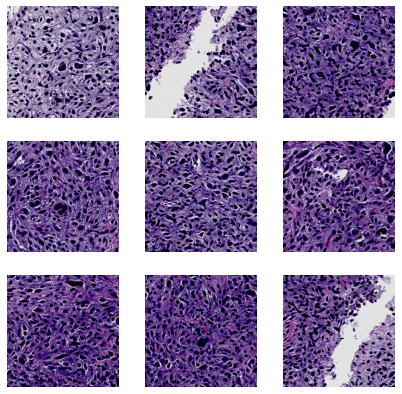

In [15]:
plt.figure(figsize=(7, 7))
for img in ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i])
        # plt.imshow(img[i] / 255)
        plt.axis("off")

In [16]:
x = img[0].numpy()
print(x.mean())
print(x.std())
print(x.min())
print(x.max())

0.4972201
0.3191406
-0.94509804
1.0


## RSP TFrecords

In [17]:
tfr_dir_name = "PDX_FIXED_RSP_DRUG_PAIR_0.1_of_tiles"
feature_description = FEA_SPEC_RSP_DRUG_PAIR

tfr_dir = (cfg.DATADIR/tfr_dir_name).resolve()
label = f"{params.tile_px}px_{params.tile_um}um"
tfr_dir = tfr_dir/label

tfr_files = [str(f) for f in sorted(tfr_dir.glob("*.tfrecords"))]
print(len(tfr_files))

6962


In [18]:
dataname="tidy_drug_pairs_all_samples"
prjname="bin_rsp_drug_pairs_all_samples"
id_name="smp"
target="Response"
split_on="Group"
n_samples=-1
trn_phase="train"
use_tile=True
use_ge=False
use_dd1=True
use_dd2=True
scale_fea=False

# Scalers for each feature set
ge_scaler, dd1_scaler, dd2_scaler = None, None, None

In [19]:
parse_fn = parse_tfrec_fn_rsp
parse_fn_train_kwargs = {
    "use_tile": use_tile,
    "use_ge": use_ge,
    "use_dd1": use_dd1,
    "use_dd2": use_dd2,
    "ge_scaler": ge_scaler,
    "dd1_scaler": dd1_scaler,
    "dd2_scaler": dd2_scaler,
    "id_name": id_name,
    "augment": params.augment,
    "application": params.base_image_model,
}
parse_fn_non_train_kwargs = parse_fn_train_kwargs.copy()
parse_fn_non_train_kwargs["augment"] = False

create_tf_data_eval_kwargs = {
    "batch_size": 32,
    "include_meta": False,
    "interleave": False,
    "parse_fn": parse_fn,
    "prefetch": None,  # 2
    "repeat": False,
    "seed": None,
    "shuffle_files": False,
    "shuffle_size": None,
}

# create_tf_data_eval_kwargs.update({"tfrecords": val_tfr_files, "include_meta": False})
# val_data = create_tf_data(
#     **create_tf_data_eval_kwargs,
#     **parse_fn_non_train_kwargs
# )

# create_tf_data_eval_kwargs.update({"tfrecords": test_tfr_files, "include_meta": True})
# test_data = create_tf_data(
#     **create_tf_data_eval_kwargs,
#     **parse_fn_non_train_kwargs
# )

# create_tf_data_eval_kwargs.update({"tfrecords": val_tfr_files, "include_meta": True})
# eval_val_data = create_tf_data(
#     **create_tf_data_eval_kwargs,
#     **parse_fn_non_train_kwargs
# )

train_tfr_files = tfr_files
create_tf_data_eval_kwargs.update({"tfrecords": train_tfr_files, "include_meta": True})
eval_train_data = create_tf_data(
    **create_tf_data_eval_kwargs,
    **parse_fn_non_train_kwargs
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


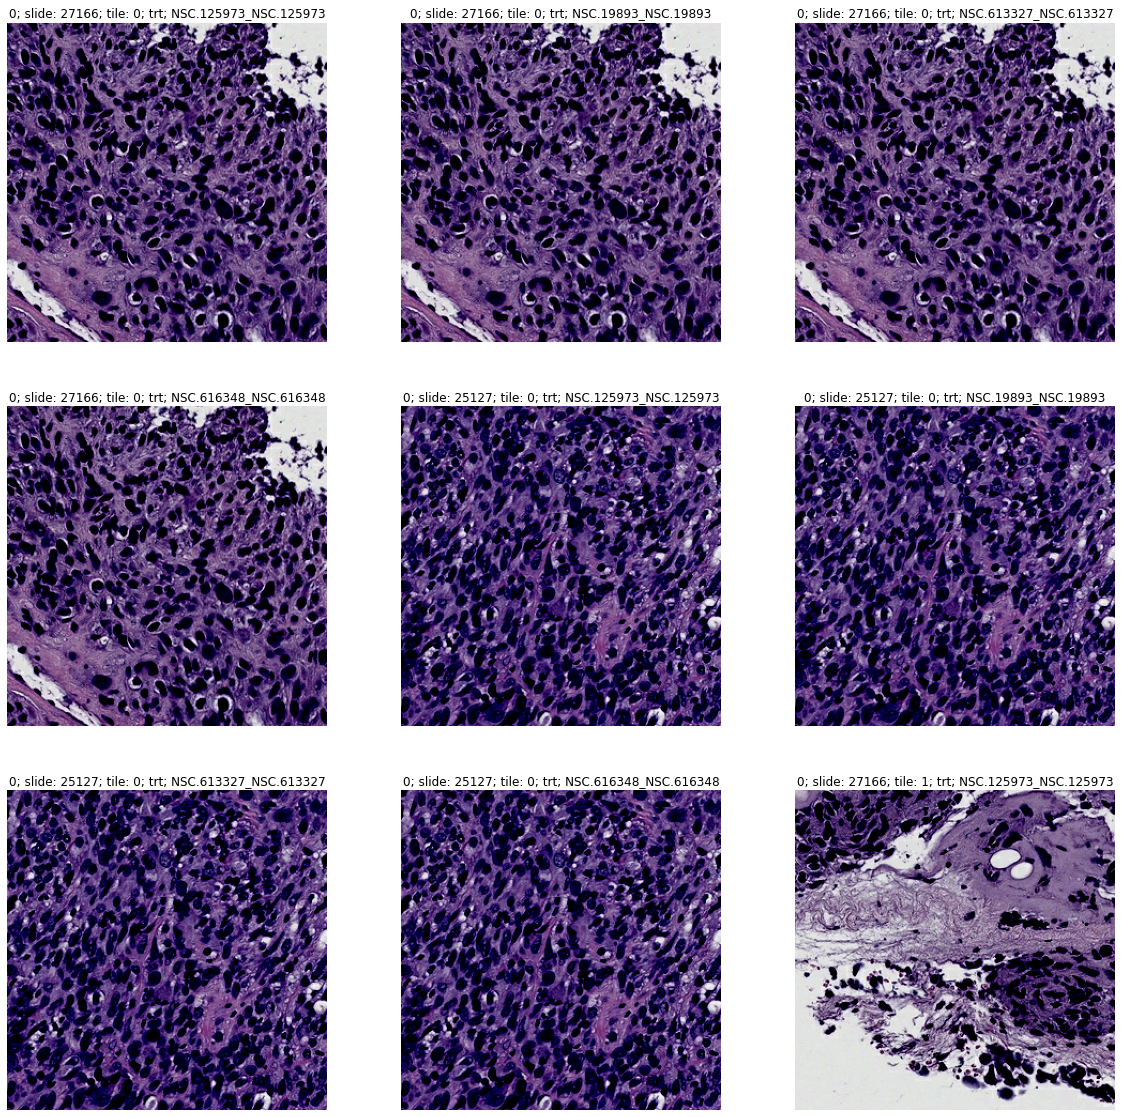

In [20]:
plt.figure(figsize=(20, 20))
for xdata, labels, meta in eval_train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(xdata["tile_image"][i].numpy()) # .astype("uint8"))
        plt.title("{}; slide: {}; tile: {}; trt; {}".format(labels.numpy()[i],
                                                            meta['image_id'].numpy()[i].decode("utf-8"),
                                                            meta['tile_id'].numpy()[i].decode("utf-8"),
                                                            meta['trt'].numpy()[i].decode("utf-8")))
        plt.axis("off")

## Check duplicates in TFRecords

In [51]:
ds = tf.data.TFRecordDataset(filenames=tfr_files)